In [1]:
#imports
from __future__ import print_function, division

import xarray as xr
import pandas as pd
import numpy as np
from datetime import timedelta
from wrf import getvar, get_basemap
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patheffects as path_effects

In [2]:
#two functions to create custom colormaps

def make_colormap(colors):
    
    from matplotlib.colors import LinearSegmentedColormap, ColorConverter
    #function for custom colorbar: http://depts.washington.edu/clawpack/users-4.6/claw/python/pyclaw/plotters/colormaps.py
    z  = np.array(sorted(colors.keys()))
    n  = len(z)
    z1 = min(z)
    zn = max(z)
    x0 = (z - z1) / (zn - z1)

    CC = ColorConverter()
    R = []
    G = []
    B = []
    for i in range(n):
        Ci = colors[z[i]]      
        if type(Ci) == str:
            RGB = CC.to_rgb(Ci)
        else:
            RGB = Ci
        R.append(RGB[0])
        G.append(RGB[1])
        B.append(RGB[2])

    cmap_dict = {}
    cmap_dict['red']   = [(x0[i],R[i],R[i]) for i in range(len(R))]
    cmap_dict['green'] = [(x0[i],G[i],G[i]) for i in range(len(G))]
    cmap_dict['blue']  = [(x0[i],B[i],B[i]) for i in range(len(B))]
    mymap = LinearSegmentedColormap('mymap',cmap_dict)
    
    return mymap 

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    #https://stackoverflow.com/questions/18926031/how-to-extract-a-subset-of-a-colormap-as-a-new-colormap-in-matplotlib
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [3]:
#frequency colormap
new_pink = plt.cm.get_cmap('viridis_r')
new_pink = truncate_colormap(new_pink, 0.125, 1.0)

#MF colormap
maria_color = ({0.:'w',
                1.0:'darkgreen'})
cmap_green = make_colormap(maria_color)

#MU colormap
maria_color = ({0.:'w',
                1.0:'darkolivegreen'})
cmap_greenolive = make_colormap(maria_color)
cmap_green = truncate_colormap(cmap_green, 0.175, 1.0)
cmap_greenolive = truncate_colormap(cmap_greenolive, 0.175, 1.0)

In [4]:
#Create basemap projection for figure using WRF proj
ncfile2_wrf_d02 = Dataset('/glade/scratch/molina/WAF_proj/WAF2019/wrf4km_ens_1/wrfout_d01_2017-01-15_09:00:00')
while True:
    dbz2_wrf_d02 = np.array([0])
    if len(dbz2_wrf_d02) == 1:
        try: 
            dbz2_wrf_d02 = getvar(ncfile2_wrf_d02, "dbz")
        except ValueError:
            continue
    if len(dbz2_wrf_d02) != 1:
        print('File Opened...')
        break
m = get_basemap(dbz2_wrf_d02)

File Opened...


In [5]:
#grab binned trajectory data
data = xr.open_dataset('/glade/work/molina/DATA/jan2017_synoptic/jan_hyfile.nc', decode_cf=True)
#mean across time
data1sum = data.sum(dim='time', skipna=True)
data1mean = data.mean(dim='time', skipna=True)
#each day of outbreak
data2 = data.sel(time='2017-01-21')
data3 = data.sel(time='2017-01-22')
data4 = data.sel(time='2017-01-23')
#extract the lat lon
x_lon, y_lat = data.coords['lons'].values, data.coords['lats'].values

In [6]:
#compute frequency
data_freq1 = data1sum.frequency.sum(dim=['pbl'], skipna=True)
data_freq2 = data2.frequency.sum(dim=['pbl'], skipna=True)
data_freq3 = data3.frequency.sum(dim=['pbl'], skipna=True)
data_freq4 = data4.frequency.sum(dim=['pbl'], skipna=True)

In [7]:
#compute mean MF (must frequency weight in the vertical since some layers have more MF than others)
data_mf1 = (np.nansum(data1mean.moisture_flux*data1sum.moisture_flux_freq,axis=0)/data1sum.moisture_flux_freq.sum(dim='pbl',skipna=True))
data_mf2 = (np.nansum(data2.moisture_flux*data2.moisture_flux_freq,axis=0)/data2.moisture_flux_freq.sum(dim='pbl',skipna=True))
data_mf3 = (np.nansum(data3.moisture_flux*data3.moisture_flux_freq,axis=0)/data3.moisture_flux_freq.sum(dim='pbl',skipna=True))
data_mf4 = (np.nansum(data4.moisture_flux*data4.moisture_flux_freq,axis=0)/data4.moisture_flux_freq.sum(dim='pbl',skipna=True))

/glade/work/molina/miniconda3/envs/python-tutorial/lib/python3.7/site-packages/xarray/core/computation.py:601: RuntimeWarning: invalid value encountered in true_divide
  result_data = func(*input_data)


In [8]:
#compute u and v winds with frequency weighting in the vertical (similar to mean, but accounting for frequency)
data_u1 = (np.nansum(data1mean.u_wind*data1sum.frequency,axis=0)/data1sum.frequency.sum(dim='pbl',skipna=True))
data_u2 = (np.nansum(data2.u_wind*data2.frequency,axis=0)/data2.frequency.sum(dim='pbl',skipna=True))
data_u3 = (np.nansum(data3.u_wind*data3.frequency,axis=0)/data3.frequency.sum(dim='pbl',skipna=True))
data_u4 = (np.nansum(data4.u_wind*data4.frequency,axis=0)/data4.frequency.sum(dim='pbl',skipna=True))
data_v1 = (np.nansum(data1mean.v_wind*data1sum.frequency,axis=0)/data1sum.frequency.sum(dim='pbl',skipna=True))
data_v2 = (np.nansum(data2.v_wind*data2.frequency,axis=0)/data2.frequency.sum(dim='pbl',skipna=True))
data_v3 = (np.nansum(data3.v_wind*data3.frequency,axis=0)/data3.frequency.sum(dim='pbl',skipna=True))
data_v4 = (np.nansum(data4.v_wind*data4.frequency,axis=0)/data4.frequency.sum(dim='pbl',skipna=True))

In [9]:
#compute MU
#first, compute frequency in the vertical
data_all_counts1 = data1sum.moisture_frequency.sum(dim=['pbl'], skipna=True)
data_all_counts2 = data2.moisture_frequency.sum(dim=['pbl'], skipna=True)
data_all_counts3 = data3.moisture_frequency.sum(dim=['pbl'], skipna=True)
data_all_counts4 = data4.moisture_frequency.sum(dim=['pbl'], skipna=True)
#second, compute mean in the vertical (with frequency weighting)
data_MU_1 = (np.nansum(data1mean.traj_uptake_below*data1sum.moisture_frequency,axis=0)/data1sum.moisture_frequency.sum(dim='pbl',skipna=True))
data_MU_2 = (np.nansum(data2.traj_uptake_below*data2.moisture_frequency,axis=0)/data2.moisture_frequency.sum(dim='pbl',skipna=True))
data_MU_3 = (np.nansum(data3.traj_uptake_below*data3.moisture_frequency,axis=0)/data3.moisture_frequency.sum(dim='pbl',skipna=True))
data_MU_4 = (np.nansum(data4.traj_uptake_below*data4.moisture_frequency,axis=0)/data4.moisture_frequency.sum(dim='pbl',skipna=True))
#now compute MU values with frequency weighting in the 2D domain
data_MU_raw1 = data_MU_1*data_all_counts1
data_pbl_ready1 = np.divide(data_MU_raw1, data_all_counts1.sum(dim=['lats','lons'],skipna=True))
data_MU_raw2 = data_MU_2*data_all_counts2
data_pbl_ready2 = np.divide(data_MU_raw2, data_all_counts2.sum(dim=['lats','lons'],skipna=True))
data_MU_raw3 = data_MU_3*data_all_counts3
data_pbl_ready3 = np.divide(data_MU_raw3, data_all_counts3.sum(dim=['lats','lons'],skipna=True))
data_MU_raw4 = data_MU_4*data_all_counts4
data_pbl_ready4 = np.divide(data_MU_raw4, data_all_counts4.sum(dim=['lats','lons'],skipna=True))

In [10]:
# open land and ocean masks to compute percentiles that follow
ocean_mask_file = xr.open_dataset('/glade/work/molina/DATA/jan2017_synoptic/ocean_basin_masks_wrfproj.nc', decode_cf=True)
conus_mask_file = xr.open_dataset('/glade/work/molina/DATA/jan2017_synoptic/conus_basin_masks_wrfproj.nc', decode_cf=True)

In [11]:
#COMPUTING PERCENTILES

#CONUS
one_conus = np.divide(np.nansum(data_pbl_ready1.values[conus_mask_file['conus'].values]),data_pbl_ready1.sum(skipna=True).values)*100
one_conus = str(round(one_conus,1))
two_conus = np.divide(np.nansum(data_pbl_ready2.values[conus_mask_file['conus'].values]),data_pbl_ready2.sum(skipna=True).values)*100
two_conus = str(round(two_conus,1))
thr_conus = np.divide(np.nansum(data_pbl_ready3.values[conus_mask_file['conus'].values]),data_pbl_ready3.sum(skipna=True).values)*100
thr_conus = str(round(thr_conus,1))
for_conus = np.divide(np.nansum(data_pbl_ready4.values[conus_mask_file['conus'].values]),data_pbl_ready4.sum(skipna=True).values)*100
for_conus = str(round(for_conus,1))
#GOM
one_gom = np.divide(np.nansum(data_pbl_ready1.values[ocean_mask_file['gom'].values]),data_pbl_ready1.sum(skipna=True).values)*100
one_gom = str(round(one_gom,1))
two_gom = np.divide(np.nansum(data_pbl_ready2.values[ocean_mask_file['gom'].values]),data_pbl_ready2.sum(skipna=True).values)*100
two_gom = str(round(two_gom,1))
thr_gom = np.divide(np.nansum(data_pbl_ready3.values[ocean_mask_file['gom'].values]),data_pbl_ready3.sum(skipna=True).values)*100
thr_gom = str(round(thr_gom,1))
for_gom = np.divide(np.nansum(data_pbl_ready4.values[ocean_mask_file['gom'].values]),data_pbl_ready4.sum(skipna=True).values)*100
for_gom = str(round(for_gom,1))
#CARIB
one_carib = np.divide(np.nansum(data_pbl_ready1.values[ocean_mask_file['carib'].values]),data_pbl_ready1.sum(skipna=True).values)*100
one_carib = str(round(one_carib,1))
two_carib = np.divide(np.nansum(data_pbl_ready2.values[ocean_mask_file['carib'].values]),data_pbl_ready2.sum(skipna=True).values)*100
two_carib = str(round(two_carib,1))
thr_carib = np.divide(np.nansum(data_pbl_ready3.values[ocean_mask_file['carib'].values]),data_pbl_ready3.sum(skipna=True).values)*100
thr_carib = str(round(thr_carib,1))
for_carib = np.divide(np.nansum(data_pbl_ready4.values[ocean_mask_file['carib'].values]),data_pbl_ready4.sum(skipna=True).values)*100
for_carib = str(round(for_carib,1))
#NATL
one_natl = np.divide(np.nansum(data_pbl_ready1.values[ocean_mask_file['natl'].values]),data_pbl_ready1.sum(skipna=True).values)*100
one_natl = str(round(one_natl,1))
two_natl = np.divide(np.nansum(data_pbl_ready2.values[ocean_mask_file['natl'].values]),data_pbl_ready2.sum(skipna=True).values)*100
two_natl = str(round(two_natl,1))
thr_natl = np.divide(np.nansum(data_pbl_ready3.values[ocean_mask_file['natl'].values]),data_pbl_ready3.sum(skipna=True).values)*100
thr_natl = str(round(thr_natl,1))
for_natl = np.divide(np.nansum(data_pbl_ready4.values[ocean_mask_file['natl'].values]),data_pbl_ready4.sum(skipna=True).values)*100
for_natl = str(round(for_natl,1))

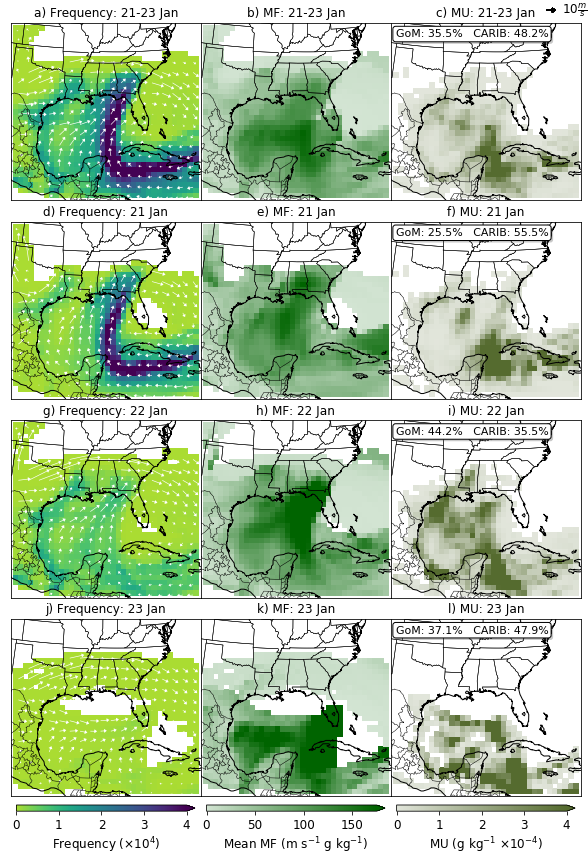

In [12]:
#########################################################################################
#########################################################################################
#########################################################################################

fig = plt.figure(figsize=(8., 11.5))

#########################################################################################

ax1 = fig.add_axes([0.0, 0.725, 0.33, 0.25])    

freq_mask1 = np.ma.masked_where(data_freq1==0, data_freq1)

ax1.pcolormesh(x_lon, y_lat, freq_mask1, vmin=0, vmax=40000, cmap=new_pink)

m.drawcoastlines()
m.drawstates()
m.drawcountries()

ax1.set_title(u'a) Frequency: 21-23 Jan', fontsize=12, loc='center')
    
wind_x, wind_y = np.meshgrid(x_lon, y_lat)
    
CSk = m.quiver(wind_x[::2, 1::2], wind_y[::2, 1::2], data_u1[::2, 1::2], data_v1[::2, 1::2], 
               color = 'w',
               angles='uv', units='xy', scale_units='xy', scale=None, linewidth=1,
               pivot='tail', headwidth=6, headlength=4, headaxislength=4.5,
               minshaft=2, minlength=1, 
               alpha=1.)

#########################################################################################

ax2 = fig.add_axes([0.33, 0.725, 0.33, 0.25])    

mf_mask1 = np.ma.masked_where(data_freq1==0, data_mf1)

ax2.pcolormesh(x_lon, y_lat, mf_mask1, vmin=0., vmax=175., cmap=cmap_green)

m.drawcoastlines()
m.drawstates()
m.drawcountries()

ax2.set_title(u'b) MF: 21-23 Jan', fontsize=12, loc='center')

#########################################################################################

ax3 = fig.add_axes([0.66, 0.725, 0.33, 0.25])    

mu_mask1 = np.ma.masked_where(data_all_counts1==0, data_pbl_ready1)
ax3.pcolormesh(x_lon, y_lat, mu_mask1, vmin=0, vmax=0.0004, cmap=cmap_greenolive)

ax3.text(0.025, 0.92, u'GoM: '+one_gom+'%   CARIB: '+one_carib+'%', fontsize=11, alpha=1., color='k', zorder=6, transform=ax3.transAxes,
         bbox=dict(facecolor='w', edgecolor='k', alpha=1., linewidth=1., boxstyle='round', pad=0.25, path_effects=[path_effects.SimplePatchShadow(),path_effects.Normal()]))

m.drawcoastlines()
m.drawstates()
m.drawcountries()

ax3.set_title(u'c) MU: 21-23 Jan', fontsize=12, loc='center')

#########################################################################################


ax4 = fig.add_axes([0.0, 0.485, 0.33, 0.25])    

freq_mask2 = np.ma.masked_where(data_freq2==0, data_freq2)

ax4.pcolormesh(x_lon, y_lat, freq_mask2, vmin=0, vmax=40000, cmap=new_pink)

m.drawcoastlines()
m.drawstates()
m.drawcountries()

ax4.set_title(u'd) Frequency: 21 Jan', fontsize=12, loc='center')

m.quiver(wind_x[::2, 1::2], wind_y[::2, 1::2], data_u2[::2, 1::2], data_v2[::2, 1::2], 
               color = 'w',
               angles='uv', units='xy', scale_units='xy', scale=None, linewidth=1,
               pivot='tail', headwidth=6, headlength=4, headaxislength=4.5,
               minshaft=2, minlength=1, 
               alpha=1.)
    

#########################################################################################


ax5 = fig.add_axes([0.33, 0.485, 0.33, 0.25])    

mf_mask2 = np.ma.masked_where(data_freq2==0, data_mf2)

ax5.pcolormesh(x_lon, y_lat, mf_mask2, vmin=0., vmax=175., cmap=cmap_green)

m.drawcoastlines()
m.drawstates()
m.drawcountries()

ax5.set_title(u'e) MF: 21 Jan', fontsize=12, loc='center')


#########################################################################################


ax6 = fig.add_axes([0.66, 0.485, 0.33, 0.25])    

mu_mask2 = np.ma.masked_where(data_all_counts2==0, data_pbl_ready2)
ax6.pcolormesh(x_lon, y_lat, mu_mask2, vmin=0, vmax=0.0004, cmap=cmap_greenolive)

ax6.text(0.025, 0.92, u'GoM: '+two_gom+'%   CARIB: '+two_carib+'%', fontsize=11, alpha=1., color='k', zorder=6, transform=ax6.transAxes,
         bbox=dict(facecolor='w', edgecolor='k', alpha=1., linewidth=1., boxstyle='round', pad=0.25, path_effects=[path_effects.SimplePatchShadow(),path_effects.Normal()]))

m.drawcoastlines()
m.drawstates()
m.drawcountries()

ax6.set_title(u'f) MU: 21 Jan', fontsize=12, loc='center')


#########################################################################################


ax7 = fig.add_axes([0.0, 0.245, 0.33, 0.25])    

freq_mask3 = np.ma.masked_where(data_freq3==0, data_freq3)

ax7.pcolormesh(x_lon, y_lat, freq_mask3, vmin=0, vmax=40000, cmap=new_pink)

m.drawcoastlines()
m.drawstates()
m.drawcountries()

ax7.set_title(u'g) Frequency: 22 Jan', fontsize=12, loc='center')
    
m.quiver(wind_x[::2, 1::2], wind_y[::2, 1::2], data_u3[::2, 1::2], data_v3[::2, 1::2], 
               color = 'w',
               angles='uv', units='xy', scale_units='xy', scale=None, linewidth=1,
               pivot='tail', headwidth=6, headlength=4, headaxislength=4.5,
               minshaft=2, minlength=1, 
               alpha=1.)


#########################################################################################


ax8 = fig.add_axes([0.33, 0.245, 0.33, 0.25])    

mf_mask3 = np.ma.masked_where(data_freq3==0, data_mf3)

ax8.pcolormesh(x_lon, y_lat, mf_mask3, vmin=0., vmax=175., cmap=cmap_green)

m.drawcoastlines()
m.drawstates()
m.drawcountries()

ax8.set_title(u'h) MF: 22 Jan', fontsize=12, loc='center')


#########################################################################################


ax9 = fig.add_axes([0.66, 0.245, 0.33, 0.25])    

mu_mask3 = np.ma.masked_where(data_all_counts3==0, data_pbl_ready3)
ax9.pcolormesh(x_lon, y_lat, mu_mask3, vmin=0, vmax=0.0004, cmap=cmap_greenolive)

ax9.text(0.025, 0.92, u'GoM: '+thr_gom+'%   CARIB: '+thr_carib+'%', fontsize=11, alpha=1., color='k', zorder=6, transform=ax9.transAxes,
         bbox=dict(facecolor='w', edgecolor='k', alpha=1., linewidth=1., boxstyle='round', pad=0.25, path_effects=[path_effects.SimplePatchShadow(),path_effects.Normal()]))

m.drawcoastlines()
m.drawstates()
m.drawcountries()

ax9.set_title(u'i) MU: 22 Jan', fontsize=12, loc='center')


#########################################################################################


ax10 = fig.add_axes([0.0, 0.005, 0.33, 0.25])    

freq_mask4 = np.ma.masked_where(data_freq4==0, data_freq4)

cs1 = ax10.pcolormesh(x_lon, y_lat, freq_mask4, vmin=0, vmax=40000, cmap=new_pink)

m.drawcoastlines()
m.drawstates()
m.drawcountries()

ax10.set_title(u'j) Frequency: 23 Jan', fontsize=12, loc='center')

m.quiver(wind_x[::2, 1::2], wind_y[::2, 1::2], data_u4[::2, 1::2], data_v4[::2, 1::2], 
               color = 'w',
               angles='uv', units='xy', scale_units='xy', scale=None, linewidth=1,
               pivot='tail', headwidth=6, headlength=4, headaxislength=4.5,
               minshaft=2, minlength=1, 
               alpha=1.)
    

#########################################################################################


ax11 = fig.add_axes([0.33, 0.005, 0.33, 0.25])    

mf_mask4 = np.ma.masked_where(data_freq4==0, data_mf4)

cs2 = ax11.pcolormesh(x_lon, y_lat, mf_mask4, vmin=0., vmax=175., cmap=cmap_green)

m.drawcoastlines()
m.drawstates()
m.drawcountries()

ax11.set_title(u'k) MF: 23 Jan', fontsize=12, loc='center')


#########################################################################################


ax12 = fig.add_axes([0.66, 0.005, 0.33, 0.25])    

mu_mask4 = np.ma.masked_where(data_all_counts4==0, data_pbl_ready4)
cs3 = ax12.pcolormesh(x_lon, y_lat, mu_mask4, vmin=0, vmax=0.0004, cmap=cmap_greenolive)

ax12.text(0.025, 0.92, u'GoM: '+for_gom+'%   CARIB: '+for_carib+'%', fontsize=11, alpha=1., color='k', zorder=6, transform=ax12.transAxes,
          bbox=dict(facecolor='w', edgecolor='k', alpha=1., linewidth=1., boxstyle='round', pad=0.25, path_effects=[path_effects.SimplePatchShadow(),path_effects.Normal()]))

m.drawcoastlines()
m.drawstates()
m.drawcountries()

ax12.set_title(u'l) MU: 23 Jan', fontsize=12, loc='center')


#########################################################################################

    
cbar_ax = fig.add_axes([0.01, 0.005, 0.31, 0.0075])
ticks_1 = [0.0001,10000.,20000.,30000.,40000.]
cbar = fig.colorbar(cs1, cax=cbar_ax, ticks=ticks_1[:], orientation='horizontal', extend='max')
cbar.ax.set_xticklabels(['0','1','2','3','4'])
cbar.ax.tick_params(labelsize=12)
cbar.set_label(r'Frequency ($ \times 10^{4}$)', fontsize=12) 

cbar_ax = fig.add_axes([0.34, 0.005, 0.31, 0.0075])
ticks_1 = [0,50.,100.,150.]
cbar = fig.colorbar(cs2, cax=cbar_ax, ticks=ticks_1[:], orientation='horizontal', extend='max')
cbar.ax.set_xticklabels(['0','50','100','150'])
cbar.ax.tick_params(labelsize=12)
cbar.set_label(r'Mean MF (m $\mathregular{s^{-1}}$ g $\mathregular{kg^{-1}}$)', fontsize=12) 

cbar_ax = fig.add_axes([0.67, 0.005, 0.31, 0.0075])
ticks_1 = [0,0.0001,0.0002,0.0003,0.0004]
cbar = fig.colorbar(cs3, cax=cbar_ax, ticks=ticks_1[:], orientation='horizontal', extend='max')
cbar.ax.set_xticklabels(['0','1','2','3','4'])
cbar.ax.tick_params(labelsize=12)
cbar.set_label(r'MU (g $\mathregular{kg^{-1}}$ $ \times 10^{-4}$)', fontsize=12) 

q_key = plt.quiverkey(CSk, 0.945, 0.9725, 10., 
                      label=r'$10 \frac{m}{s}$', labelpos='E',coordinates='figure',
                      color='k', zorder=99, fontproperties={'weight': 'bold', 'size':12})


#########################################################################################
#########################################################################################
#########################################################################################


plt.savefig('/glade/work/molina/DATA/temp_figs/mwr2019_fig6.png', bbox_inches='tight', dpi=1200)
plt.savefig('/glade/work/molina/DATA/temp_figs/mwr2019_fig6_lowdpi.png', bbox_inches='tight', dpi=200)
plt.show()
plt.close()


#########################################################################################
#########################################################################################
#########################################################################################